# Assignment 2: Naive Bayes and Text Classification

Only use the already imported library `numpy`. Make sure that the `spamham.txt` dataset is in the same directory as the notebook.

List your team members (name and immatriculation number) in the following cell:

<h3>

Min Wang 3440557

Sisi Miao 3377882
    
Dominik Sellenthin 2836308    
</h3>


In [6]:
# Load required packages and dataset. Do not modify.
import numpy as np

def load_spamham_dataset():
    import string
    
    with open('spamham.txt', mode='r', encoding='utf-8') as f:
        rows = [l.strip().split('\t')[:2] for l in f]
    
    y, X = zip(*rows)
    X =[x.translate(str.maketrans('', '', string.punctuation)).lower().split() for x in X]
    
    return X, y
    
X, y = load_spamham_dataset()

print('Sample:')
print(f'{y[0]}: {X[0]}')
print(f'{y[2]}: {X[2]}')

Sample:
ham: ['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
spam: ['free', 'entry', 'in', '2', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', '21st', 'may', '2005', 'text', 'fa', 'to', '87121', 'to', 'receive', 'entry', 'questionstd', 'txt', 'ratetcs', 'apply', '08452810075over18s']


## Task 2: Spam Classification with Naive Bayes

Check out the description of the dataset at [https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection).

Implement a Naive Bayes classifier with Laplace smoothing to detect whether a text message is spam or ham (not spam).

A text message is represented by a list of string tokens as shown above.
The classification target is binary and the two possible labels are the strings `'spam'` and `'ham'`.

Fill out the methods in `NaiveBayesSpamClassifier` to train (`fit`) and predict (`predict`). Feel free to introduce new fields and methods based on your needs, but the methods `fit` and `predict` are required and their interface should not be changed.

Hint: Try to map the text messages to word frequency vectors by counting how often each word occurs in a message.

In [7]:
# Easy-version --- data preprocessing
class CountVectorizer_1(object):
    def __init__(self, pass_stop=False):
        self.pass_stop = pass_stop  # default: don't filter
    
    def fit(self, X):
        
        self.features = set()
        for line in X:
            for word in line:
                # self-define filtering rules
                if self.pass_stop:  
                    if len(word)==1:
                        continue
                self.features.add(word)
        # store features
        self.features = np.sort(list(self.features))
        self.feature_index = np.arange(len(self.features)).astype(int)
        self.feature_dict = {}
        for i in range(len(self.features)):
            self.feature_dict[str(self.features[i])] = self.feature_index[i]
        
    def transform(self, X):
        from scipy import sparse
        rows = []
        columns = []
        for i in range(len(X)):
            for word in X[i]:
                if word in self.feature_dict:
                    rows.append(i)
                    columns.append(self.feature_dict[word])
        vals = np.ones((len(rows),)).astype(int)

        return sparse.csr_matrix((vals, (rows, columns)), shape=(len(X), len(self.feature_index)))


    def fit_transform(self, X):
        self.fit(X)
        X_ = self.transform(X)
        return X_

In [8]:
# Implement your solution here.
# P(Y|X) = P(X|Y)P(Y) / P(X)
class NaiveBayesSpamClassifier(object):
    def __init__(self):
        pass
    
    
    def fit(self, X, y):
        """
        X is a list of `n` text messages. Each text message is a list of strings with at least length one.
        y is a list of `n` labels either the string 'spam' or the string 'ham'.
        """
        X_train = X.toarray()
        y_train = np.array(y)
        train_num = y_train.shape[0]
        feature_num = X_train.shape[1]
        # P(Y=ham) and P(Y=spam) ---- Prior of Y
        ham_num = np.sum(y_train=='ham')
        spam_num = np.sum(y_train=='spam')
        
        # Laplace Smooth
        self.Py_ham = (ham_num + 1) / (train_num + 2)
        self.Py_spam = (spam_num + 1) / (train_num + 2)
        
        # P(X) for each feature ----- Prior of X's features
        ham_count = np.ones(feature_num)
        spam_count = np.ones(feature_num)
        ham_denom, spam_denom = feature_num, feature_num
        for i in range(train_num):
            if y_train[i] == 'ham':
                ham_count += X_train[i]
                ham_denom += np.sum(X_train[i])
            else:
                spam_count += X_train[i]
                spam_denom += np.sum(X_train[i])
        # avoid multi-multiply, use log() here
        self.P_ham_prob = np.log(ham_count/ham_denom)
        self.P_spam_prob = np.log(spam_count/spam_denom)
        
    def predict(self, X):
        """
        X is a list of `n` text messages. Each text message is a list of strings with at least length one.
        The method returns a list of `n` strings, i.e. classification labels ('spam' or 'ham').
        """
        X_test = X.toarray()
        test_num = X_test.shape[0]
        P_ham, P_spam = np.zeros(test_num), np.zeros(test_num)
        y_hat = ['ham'] * test_num
        for i in range(test_num):
            P_ham[i] = np.sum(self.P_ham_prob * X_test[i]) + np.log(self.Py_ham)
            P_spam[i] = np.sum(self.P_spam_prob * X_test[i]) + np.log(self.Py_spam)
            
            threshold = 1.0  # tolerate spam in case misclassify ham into spam
            
            if P_ham[i] + threshold > P_spam[i]:
                y_hat[i] = 'ham'
            else:
                y_hat[i] = 'spam'
            
        return y_hat

In [9]:
# The following code will evaluate your classifier.
class HamClassifier(object):
    """
    This classifier is a primitive baseline, which just predicts the most common class each time.
    Naive Bayes should definitely beat this.
    """
    def fit(self, X, y): pass
    def predict(self, X): return (X.shape[0])*['ham']

    
def train_evaluate(classifier, X, y):
    from sklearn.metrics import confusion_matrix, accuracy_score
    from sklearn.model_selection import train_test_split
    
    # Apply train-test split.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)
    
    counter = CountVectorizer_1()
    X_train = counter.fit_transform(X_train)
    X_test = counter.transform(X_test)
    
    # Inititialize and train classifier.
    classifier.fit(X_train, y_train)
    # Evaluate classifier on test data.
    yhat_test = classifier.predict(X_test)
    cmatrix = confusion_matrix(y_test, yhat_test, labels=['ham', 'spam'])
    accuracy = accuracy_score(y_test, yhat_test)

    return cmatrix, accuracy


def plot_confusion_matrix(cmatrix, classifier_name):
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(1, 1)
    ax.matshow(cmatrix, cmap='Greens')
    for x in (0, 1):
        for y in (0, 1):
            ax.text(x, y, cmatrix[y, x])
    ax.set_xlabel('predicted label')
    ax.set_ylabel('true label')
    ax.set_xticklabels(['', 'ham', 'spam'])
    ax.set_yticklabels(['', 'ham', 'spam'])
    ax.set_title(classifier_name)

In [10]:
ham_classifier = HamClassifier()
your_classifier = NaiveBayesSpamClassifier()
ham_cmatrix, ham_accuracy = train_evaluate(ham_classifier, X, y)
your_cmatrix, your_accuracy = train_evaluate(your_classifier, X, y)

ham_accuracy is: 0.8637
your_accuracy is: 0.9868 


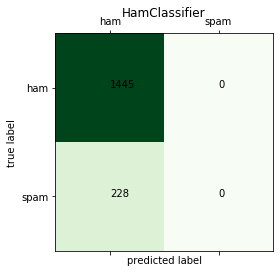

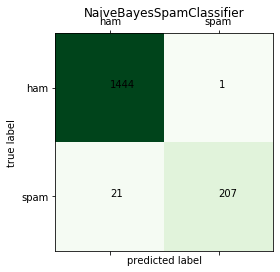

In [11]:
plot_confusion_matrix(ham_cmatrix, 'HamClassifier')
print("ham_accuracy is: %.4f" % ham_accuracy)
plot_confusion_matrix(your_cmatrix, 'NaiveBayesSpamClassifier')
print("your_accuracy is: %.4f "% your_accuracy)